# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

### Business Understanding
We will go through the below six questions to see how each gender are responsive to each type of offer.
- For each reward and events(offer received, offer viewed and offer completed) how many customer in each offer type?
- For each gender in each events what is the percentage of customers?
- Which offer type completed more?
- For each gender and reward how many customer response for each offer type?
- For each gender and reward what is the average income in each offer type
- For each gender and reward and offer type how many customers in each money required to be spent to receive reward?

### Data Preparing :

In [1]:
# import laibraies and load data
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
#show few rows of portfolio data
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
#show few rows of profile data
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
#show few rows of transcript data
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [5]:
#show information about the portfolio data
# (how many rows and columns, missing data, data types)
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [6]:
#show information about the profile data
# (how many rows and columns, missing data, data types)
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [7]:
#show information about the transcript data
# (how many rows and columns, missing data, data types)
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [8]:
#drop missing values from profile data
profile = profile.dropna()

In [9]:
#drop O value from gender column
profile = profile[profile.gender != 'O']

In [10]:
# restructure value column(that have dictionary data) in transcript 
# in which keys will used as column and its item will be value.
df= pd.DataFrame(transcript.value.values.tolist(), index=transcript.index)

In [11]:
#show some rows of new dataframe of dictionary data was in value column
df.head()

,amount,offer id,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [12]:
#combine offer id and offer_id columns 
df['offer_id'] = df['offer_id'].str.cat(df['offer id'],na_rep='')

In [13]:
#delete offer id column
df = df.drop(columns='offer id')

In [14]:
#check 
df.head()

,amount,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [15]:
#merge df with transcript
transcript = pd.merge( transcript, df, left_index=True, right_index=True)

In [16]:
#fill nan on reward and amount with 0 
transcript = transcript.fillna(0)

In [17]:
#remove value columns from transcript
transcript = transcript.drop(columns='value')

In [18]:
#check
transcript.head(2)

,event,person,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0


In [19]:
#check dublicates values
sum(transcript.duplicated())

397

In [20]:
#remove duplicates
transcript = transcript.drop_duplicates() 

In [21]:
#change person column in transcript to person_id and id in profile to person_id
# and id in portfolio to offer_id
transcript = transcript.rename(columns={"person": "person_id"})
profile = profile.rename(columns={"id": "person_id"})
portfolio = portfolio.rename(columns={"id": "offer_id"})

In [22]:
#merge three dataframe (transcript, profile, portfolio)
master_df = transcript.merge(profile,how='inner', on ='person_id')

In [23]:
master_df = master_df.merge(portfolio,how='inner', on ='offer_id') 

In [24]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146247 entries, 0 to 146246
Data columns (total 15 columns):
event               146247 non-null object
person_id           146247 non-null object
time                146247 non-null int64
amount              146247 non-null float64
offer_id            146247 non-null object
reward_x            146247 non-null float64
age                 146247 non-null int64
became_member_on    146247 non-null int64
gender              146247 non-null object
income              146247 non-null float64
channels            146247 non-null object
difficulty          146247 non-null int64
duration            146247 non-null int64
offer_type          146247 non-null object
reward_y            146247 non-null int64
dtypes: float64(3), int64(6), object(6)
memory usage: 17.9+ MB


In [25]:
#delete columns not need
master_df = master_df.drop(columns=['time','became_member_on','channels'])

In [26]:
master_df.head()

,event,person_id,amount,offer_id,reward_x,age,gender,income,difficulty,duration,offer_type,reward_y
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,75,F,100000.0,5,7,bogo,5
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,75,F,100000.0,5,7,bogo,5
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,75,F,100000.0,5,7,bogo,5
3,offer received,e2127556f4f64592b11af22de27a7932,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,68,M,70000.0,5,7,bogo,5
4,offer viewed,e2127556f4f64592b11af22de27a7932,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,68,M,70000.0,5,7,bogo,5


### Exploring Data

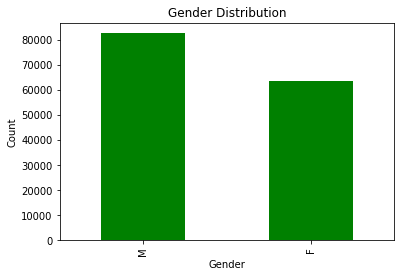

In [27]:
#gender Distribution
master_df.gender.value_counts().plot(kind='bar',color='green')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show();

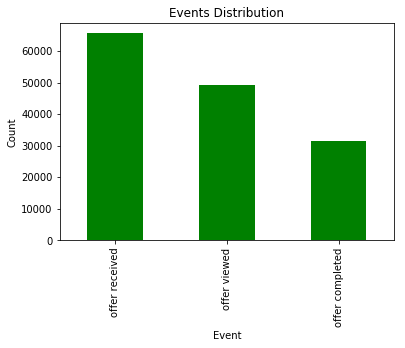

In [28]:
#events Distribution
master_df.event.value_counts().plot(kind='bar',color='green')
plt.title('Events Distribution')
plt.xlabel('Event')
plt.ylabel('Count')
plt.show();

In [29]:
#Percentage for each event
master_df.event.value_counts()/master_df.event.shape[0]

offer received     0.448454
offer viewed       0.335644
offer completed    0.215902
Name: event, dtype: float64

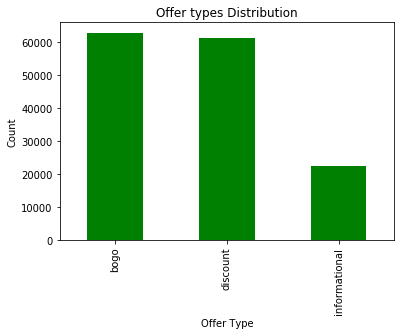

In [30]:
#offer_type Distribution
master_df.offer_type.value_counts().plot(kind='bar',color='green')
plt.title('Offer types Distribution')
plt.xlabel('Offer Type')
plt.ylabel('Count')
plt.show();

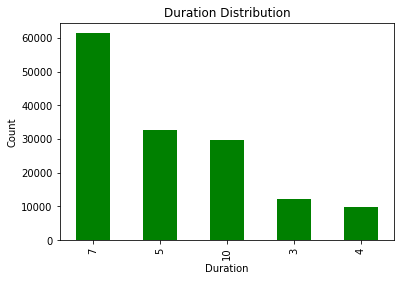

In [31]:
#offer duration Distribution
master_df.duration.value_counts().plot(kind='bar',color='green');
plt.title('Duration Distribution')
plt.xlabel('Duration')
plt.ylabel('Count')
plt.show();

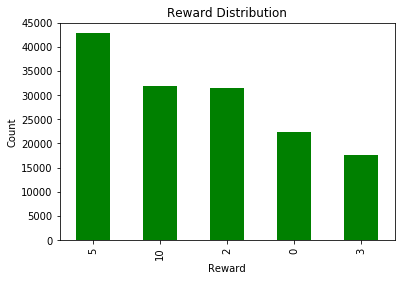

In [32]:

master_df.reward_y.value_counts().plot(kind='bar',color='green');
plt.title('Reward Distribution')
plt.xlabel('Reward')
plt.ylabel('Count')
plt.show();

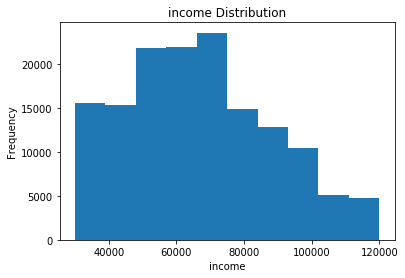

In [33]:
#income distribution
master_df['income'].plot(kind='hist')
plt.title('income Distribution')
plt.xlabel('income')
plt.show();

### Analyzing Data
#### First Question 
For each reward and events(offer received, offer viewed and offer completed) how many customer in each offer type?

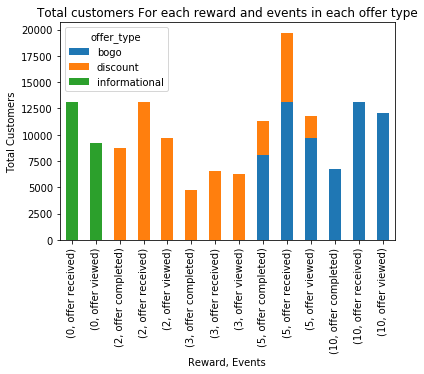

In [34]:
master_df.groupby(['reward_y','event','offer_type'])['person_id'].count().unstack().plot(
    kind='bar',stacked=True)
plt.title("Total customers For each reward and events in each offer type")
plt.xlabel('Reward, Events')
plt.ylabel('Total Customers')
plt.show();

#### Sconed Question 
For each gender in each events what is the percentage of customers?

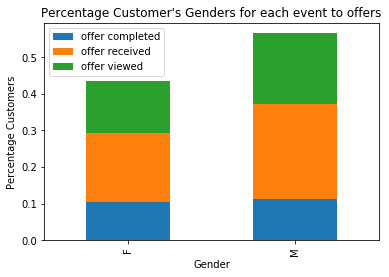

In [35]:
# percentage of customer grouped by gender and events and plot it
perce_customer_gender_event = \
master_df.groupby(['gender','event'])['person_id'].count()/master_df.gender.shape[0]
perce_customer_gender_event.unstack().plot(kind='bar',stacked=True)
plt.title("Percentage Customer's Genders for each event to offers")
plt.xlabel('Gender')
plt.ylabel('Percentage Customers')
plt.rcParams["figure.figsize"] = (8,6)
plt.legend(loc='best')
plt.show();

In [36]:
perce_customer_gender_event

gender  event          
F       offer completed    0.104727
        offer received     0.187737
        offer viewed       0.142129
M       offer completed    0.111175
        offer received     0.260716
        offer viewed       0.193515
Name: person_id, dtype: float64

 

#### Third Question 
Which offer type completed more?

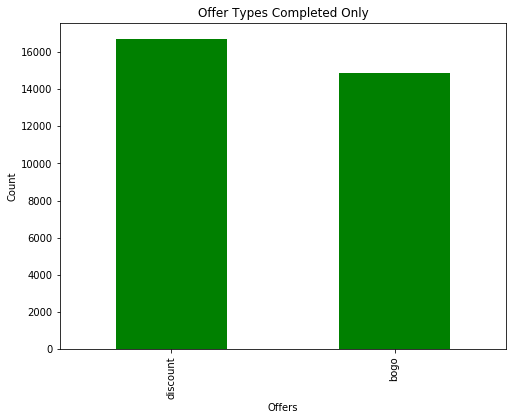

In [37]:
#keep values that under offer completed event only 
completed_offer = master_df[master_df['event'] == 'offer completed']
#offer type completed only
completed_offer.offer_type.value_counts().plot(kind='bar',color='green')
plt.title("Offer Types Completed Only")
plt.xlabel('Offers')
plt.ylabel('Count')
plt.rcParams["figure.figsize"] = (8,6)
plt.show();

اوفر الديسكاونت اعلى تجاوب 

#### Fourth Question
For each gender and reward how many customer response for each offer type?


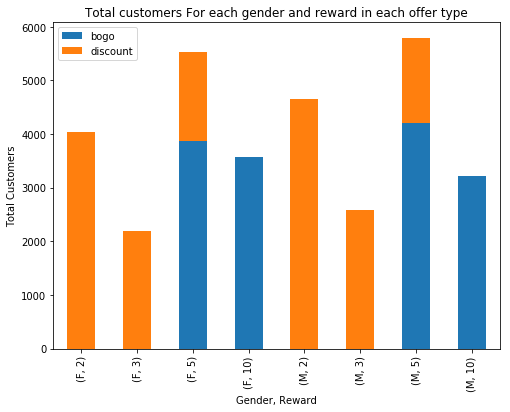

In [38]:
completed_offer.groupby(['gender','reward_y', 'offer_type',
                         ])['person_id'].count().unstack().plot(kind='bar',stacked=True)
plt.title("Total customers For each gender and reward in each offer type")
plt.xlabel('Gender, Reward')
plt.ylabel('Total Customers')
plt.legend(loc='best')
plt.show();

In [39]:
completed_offer.groupby(['gender','reward_y', 'offer_type',
                         ])['person_id'].count()

gender  reward_y  offer_type
F       2         discount      4031
        3         discount      2192
        5         bogo          3869
                  discount      1659
        10        bogo          3565
M       2         discount      4662
        3         discount      2588
        5         bogo          4208
                  discount      1584
        10        bogo          3217
Name: person_id, dtype: int64

  
  #### Fifth Question
For each gender and reward what is the average income in each offer type?


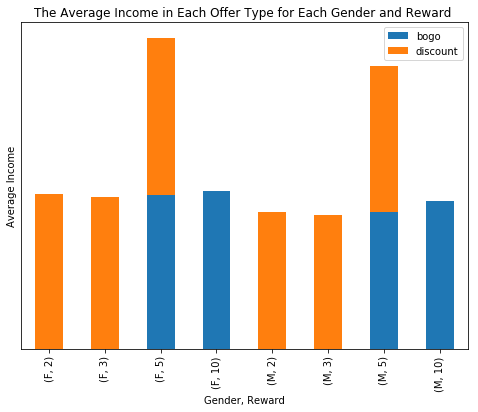

In [40]:
completed_offer.groupby(['gender','reward_y', 'offer_type',
                         ])['income'].mean().unstack().plot(kind='bar',stacked=True)
plt.title("The Average Income in Each Offer Type for Each Gender and Reward ")
plt.xlabel('Gender, Reward')
plt.ylabel('Average Income')
plt.yticks([])
plt.legend(loc='best')
plt.show();

In [41]:
completed_offer.groupby(['gender','reward_y', 'offer_type',
                         ])['income'].mean()

gender  reward_y  offer_type
F       2         discount      73007.690399
        3         discount      71599.908759
        5         bogo          72561.902300
                  discount      74547.317661
        10        bogo          74815.427770
M       2         discount      64771.986272
        3         discount      63066.846986
        5         bogo          64740.494297
                  discount      69068.181818
        10        bogo          69770.904569
Name: income, dtype: float64

 

#### sixth Question
For each gender and reward and offer type how many customers in each money required to be spent to receive reward?

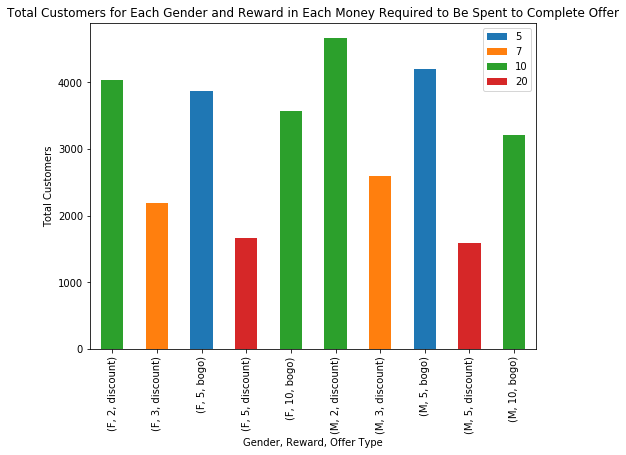

In [42]:

completed_offer.groupby(['gender','reward_y','offer_type','difficulty'
                         ])['person_id'].count().unstack().plot(kind='bar',stacked=True)
plt.title("Total Customers for Each Gender and Reward in Each Money Required to Be Spent to Complete Offer")
plt.xlabel('Gender, Reward, Offer Type')
plt.ylabel('Total Customers')
plt.legend(loc='best')
plt.show();